# Audio Classification Using Deep Learning

## 4. Deep Learning Model Optimisation

### Hyperparameter optimisation

In the previous section, we use a manual hyperparameter configuration to train the model. In this section, we will apply a Bayesian optimisation technique to smartly find the optimised hyperparameters. There are several hyperparameter optimisation packages available out there. I have previously ever used two packages:
* [BaysesianOptimisation](https://github.com/fmfn/BayesianOptimization)
* [Hyperopt](http://hyperopt.github.io/hyperopt/)

I recently came across a relatively new hyperparameter optimisation package called [Optuna](https://optuna.org/). After reading an excellent [article](https://towardsdatascience.com/optuna-vs-hyperopt-which-hyperparameter-optimization-library-should-you-choose-ed8564618151) comparing head-to-head between Hyperopt vs Optuna, I'm interested to give Optuna a try. I found that Optuna is really simple, convenient, yet powerful. 

Before running hyperparameter optimisation, we firstly load the features.

In [6]:
import os
import numpy as np
import h5py

num_labels = 10
feature_dir = 'features'
result_dir = 'results'
feature = 'mfcc' #['mel','mfcc']
model_type = 'lstm' # ['cnn','lstm']

# Loading feature from training, validation, and testing sets
train_file = os.path.join(feature_dir,'mel_mfcc_train.h5')
print ("Loading feature from file: "+train_file)
with h5py.File(train_file,'r') as f:
    x_train = f[feature+'_train'][()]
    y_train = f['y_train'][()]
    
valid_file = os.path.join(feature_dir,'mel_mfcc_valid.h5')
print ("Loading feature from file: "+valid_file)
with h5py.File(valid_file,'r') as f:
    x_valid = f[feature+'_valid'][()]
    y_valid = f['y_valid'][()]

Loading feature from file: features\mel_mfcc_train.h5
Loading feature from file: features\mel_mfcc_valid.h5


### Define an objective function

The procedure of using Optuna is as follows:
* Define an objective function to be optimized. Here, we define the objective function as the accuracy on the validation data.
* Suggest hyperparameter values using trial object. Several hyperparameter types are trials.suggest_categorical (for categorical parameters), trials.suggest_int (for integers), trials.suggest_uniform and trials.suggest_loguniform (for floats), etc.
* Create a study object and invoke the optimize method over n_trials or timeout.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

input_shape = (x_train.shape[1], x_train.shape[2])

def objective(trial):
    # hyperparameter search space
    units = trial.suggest_int("units", 25, 250)
    dropout = trial.suggest_categorical("dropout", [0, 0.1, 0.2, 0.3, 0.4])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 96, 128])
    epochs = trial.suggest_int("epochs", 5, 30)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    
    model = Sequential()
    model.add(LSTM(units=units,
                   input_shape=input_shape,
                   dropout=dropout))
    model.add(Dense(num_labels, activation='softmax'))
        
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(lr=lr), 
                  metrics=['accuracy']) 
        
    model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0,
              validation_data=(x_valid,y_valid), callbacks=[TFKerasPruningCallback(trial, 'val_loss')])
    
    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(x_valid,y_valid,batch_size=batch_size,verbose=0)
    
    return score[1]

### Run the hyperparameter optimisation

Due to limited compute capability, here, we set n_trials = 2, and timeout = None. It means that the hyperparameter optimisation process will stop after 2 trials. For example, if we timeout = 100, the hyperparameter optimisation process will stop after 100 seconds or after 2 trials (depending on which one reaching the treshold first).

However, I have previously run the hyperparameter optimisation with n_trials=100 and timeout=21600. The results have been stored into .csv files within `results` directory. The results correspond to only LSTM model with MFCC feature.

In [15]:
import optuna
from optuna.integration import TFKerasPruningCallback

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))


[I 2020-03-19 21:07:22,676] Finished trial#0 resulted in value: 0.9142736196517944. Current best value is 0.9142736196517944 with parameters: {'units': 98, 'dropout': 0.4, 'batch_size': 96, 'epochs': 10, 'lr': 0.002091297654842951}.
[I 2020-03-19 21:11:03,937] Finished trial#1 resulted in value: 0.8788006901741028. Current best value is 0.9142736196517944 with parameters: {'units': 98, 'dropout': 0.4, 'batch_size': 96, 'epochs': 10, 'lr': 0.002091297654842951}.


Number of finished trials: 2


### Store the optimisation results

After the hyperparameter optimisation process is finised, we can store the all the trials and inspect the best trial (best hyperparameters). Here is an illustration of all the trial and the best trial from n_trials=2.

In [16]:
import pandas as pd

df_trial = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
print(df_trial)
trial_file = os.path.join(result_dir,feature+'_'+model_type+'_trial.csv')
print ("Storing trial into a file: "+trial_file)
#df_trial.to_csv(trial_file) # this is commented because we don't want to overwrite the existing results (longer n_trials)

print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))
    
best_trial_file = os.path.join(result_dir,feature+'_'+model_type+'_best_trial.pkl')
print ("Storing best trial into a file: "+best_trial_file)
#with open(best_trial_file, 'wb') as f: 
#    pickle.dump(best_trial, f) # this is commented because we don't want to overwrite the existing results (longer n_trials)

   number     value  params_batch_size  params_dropout  params_epochs  \
0       0  0.914274                 96             0.4             10   
1       1  0.878801                 32             0.4             13   

   params_lr  params_units     state  
0   0.002091            98  COMPLETE  
1   0.006425            52  COMPLETE  
Storing trial into a file: results\mfcc_lstm_trial.csv
Best trial:
  Value: 0.9142736196517944
  Params: 
    units: 98
    dropout: 0.4
    batch_size: 96
    epochs: 10
    lr: 0.002091297654842951
Storing best trial into a file: results\mfcc_lstm_best_trial.pkl


### Visualise the hyperparameter optimisation results

Loading the hyperparameter optimisation results that have been previously stored.

In [8]:
import pandas as pd

trial_file = os.path.join(result_dir,feature+'_'+model_type+'_trial.csv')
print ("Loading trial from a file: "+trial_file)
df_trial = pd.read_csv(trial_file,index_col=0)

dropout_space = [0, 0.1, 0.2, 0.3, 0.4]

params_units = df_trial['params_units'].to_numpy()
params_epochs = df_trial['params_epochs'].to_numpy() 
params_batch_size = df_trial['params_batch_size'].to_numpy()
params_dropout = df_trial['params_dropout'].to_numpy()
params_lr = df_trial['params_lr'].to_numpy()
accuracy = df_trial['value'].to_numpy()

Loading trial from a file: results\mfcc_lstm_trial.csv


Visual illustration of all the trials run during hyperparameter optimisation.

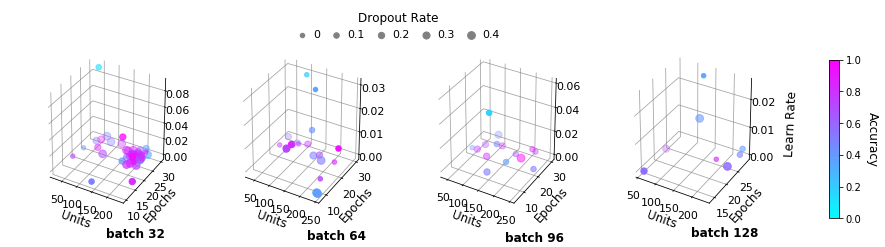

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from plotting import customise_scatter, legend_idx, plot_legend

label = ['Units','Epochs','Batch Size','Dropout Rate','Learning Rate']
hyperparam = [params_units, params_epochs,params_batch_size,params_dropout,params_lr]
num_hyperparam = len(hyperparam)
color = cm.gist_rainbow(np.linspace(0.,1.,num_hyperparam))

batch_idx_32 = np.where(params_batch_size==32)[0]
batch_idx_64 = np.where(params_batch_size==64)[0]
batch_idx_96 = np.where(params_batch_size==96)[0]
batch_idx_128 = np.where(params_batch_size==128)[0]
batch_idx = [batch_idx_32, batch_idx_64, batch_idx_96, batch_idx_128]
cbarlabel = 'Accuracy'
dropout_size = params_dropout*100 + 20

cmap = 'cool'
fig = plt.figure(figsize=(14,4))
plt.subplots_adjust(wspace=0)
ax0 = fig.add_subplot(1,4,1,projection='3d')
scat = ax0.scatter3D(params_units[batch_idx[0]],params_epochs[batch_idx[0]],params_lr[batch_idx[0]],c=accuracy[batch_idx[0]],
                     s=dropout_size[batch_idx[0]],cmap=cmap,vmin=0, vmax=1)
customise_scatter(ax0,xlabel='Units',ylabel='Epochs',zlabel='')
ax1 = fig.add_subplot(1,4,2,projection='3d')
scat = ax1.scatter3D(params_units[batch_idx[1]],params_epochs[batch_idx[1]],params_lr[batch_idx[1]],c=accuracy[batch_idx[1]],
                     s=dropout_size[batch_idx[1]],cmap=cmap,vmin=0, vmax=1)
customise_scatter(ax1,xlabel='Units',ylabel='Epochs',zlabel='')
ax2 = fig.add_subplot(1,4,3,projection='3d')
scat = ax2.scatter3D(params_units[batch_idx[2]],params_epochs[batch_idx[2]],params_lr[batch_idx[2]],c=accuracy[batch_idx[2]],
                     s=dropout_size[batch_idx[2]],cmap=cmap,vmin=0, vmax=1)
customise_scatter(ax2,xlabel='Units',ylabel='Epochs',zlabel='')
ax3 = fig.add_subplot(1,4,4,projection='3d')
scat = ax3.scatter3D(params_units[batch_idx[3]],params_epochs[batch_idx[3]],params_lr[batch_idx[3]],c=accuracy[batch_idx[3]],
                     s=dropout_size[batch_idx[3]],cmap=cmap,vmin=0, vmax=1)
customise_scatter(ax3,xlabel='Units',ylabel='Epochs',zlabel='')
ax3.text(325,32,0.00075,'Learn Rate',zdir='z',fontsize=12,rotation=0,va='bottom',ha='left')

#ax2.zaxis.set_label_coords(0,0)
leg_idx = legend_idx(params_dropout,dropout_space)
for i in range(len(leg_idx)):
    ax1.scatter3D(params_units[leg_idx[i]],params_epochs[leg_idx[i]],params_lr[leg_idx[i]],c=np.array([accuracy[leg_idx[i]]]), 
                  s=dropout_size[leg_idx[i]],cmap=cmap,vmin=0, vmax=1, label=str(dropout_space[i]))
plot_legend(ax1,leg_idx)

cbax = fig.add_axes([0.94, 0.2, 0.01, 0.55]) 
cbar = fig.colorbar(scat,cax=cbax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom",fontsize=12)

axes = [ax0, ax1, ax2, ax3]
ax_idx = ['batch 32','batch 64','batch 96','batch 128']
x = [250,250,250,250]
y = [0,0,0,5]
z = [-0.015,-0.01,-0.025,-0.002]
for i in range(4):
    axes[i].text(x[i], y[i], z[i], ax_idx[i], fontsize=12,fontweight='bold', va='top')